# Getting started

I'll start by loading packages, importing the data, and taking a look at it.

In [1]:
# Import data science packages
import pandas as pd
import numpy as np
import matplotlib.pylab as pylab
from matplotlib import pyplot as plt

# Set global parameters for plots
params = {'figure.figsize': (8, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize': 'large'}
pylab.rcParams.update(params)

# Import data
nyc_2019 = pd.read_csv('AB_NYC_2019.csv')

# Look at data
nyc_2019.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,19/10/2018,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,21/05/2019,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,05/07/2019,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,19/11/2018,0.10,1,0


In [2]:
# Summary of data
nyc_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

'Last review' is an object when it should be a timestamp. I'll convert it.

In [3]:
# Convert 'last_review' into Timestamp
nyc_2019['last_review'] = pd.to_datetime(nyc_2019.last_review, format = '%d/%m/%Y')

# Q: What is the rough time window of our data?
nyc_2019.last_review.describe()

# A: March 2011 - July 2019

count                   38843
unique                   1764
top       2019-06-23 00:00:00
freq                     1413
first     2011-03-28 00:00:00
last      2019-07-08 00:00:00
Name: last_review, dtype: object

# Consistency: id, host_id, and host_name

I want to run some quick checks to verify the consistency of labels etc in the data set. I'll start with id, host_id, and host_name.

In [4]:
# Are id numbers unique?
len(nyc_2019.id.unique()) == len(nyc_2019)

True

No two hosts have the same id.

In [5]:
# Checking calculated_host_listings_count
listings_by_host_id = nyc_2019.groupby(['host_id', 'calculated_host_listings_count']).id.count().reset_index()
listings_by_host_id.rename(columns = {'id' : 'recalculated_listings_count'}, inplace = True)

# Return data frame with host_ids for which calculated_host_listings_count doesn't match my calculation
listings_by_host_id[listings_by_host_id.calculated_host_listings_count != listings_by_host_id.recalculated_listings_count]

,host_id,calculated_host_listings_count,recalculated_listings_count


The data frame is empty so 'calculated_host_listings_count' is correct.

In [6]:
# Do same host ids have same host names?
host_names_by_host_id = nyc_2019.groupby('host_id').host_name.nunique().reset_index()
host_ids_without_names = host_names_by_host_id[host_names_by_host_id.host_name != 1]

# Suggests some host ids don't have names. Check against original data set
host_ids_without_names = nyc_2019[nyc_2019.host_id.isin(host_ids_without_names['host_id'])]
len(host_ids_without_names)

21

21 host ids don't have host names, but no host id has more than one name attached.

# Consistency: neighbourhood, neighbourhood_group, and room_type

Test consistency in labelling of neighbourhoods (capitalisation etc.)

In [7]:
# Number of listings in different neighbourhoods
listings_by_neighbourhood = nyc_2019.groupby(['neighbourhood_group', 'neighbourhood']).id.count().reset_index()
listings_by_neighbourhood.rename(columns = {'id' : 'num_listings'}, inplace = True)

# and in different neighbourhood groups
listings_by_neighbourhood_group = listings_by_neighbourhood.groupby('neighbourhood_group').num_listings.sum().reset_index()

listings_by_neighbourhood_group

,neighbourhood_group,num_listings
0,Bronx,1091
1,Brooklyn,20104
2,Manhattan,21661
3,Queens,5666
4,Staten Island,373


There are 5 neighbourhood groups. They are consistently labelled. What about neighbourhoods themselves?

In [8]:
# How many neighbourhoods are in each group?
num_neighbourhoods_by_neighbourhood_group = listings_by_neighbourhood.groupby('neighbourhood_group').neighbourhood.count().reset_index()
num_neighbourhoods_by_neighbourhood_group.rename(columns = {'neighbourhood' : 'num_neighbourhoods'}, inplace = True)

num_neighbourhoods_by_neighbourhood_group

,neighbourhood_group,num_neighbourhoods
0,Bronx,48
1,Brooklyn,47
2,Manhattan,32
3,Queens,51
4,Staten Island,43


In [9]:
# Check if any neighbourhood appears in two groups
num_neighbourhood_groups_by_neighbourhood = listings_by_neighbourhood.groupby('neighbourhood').neighbourhood_group.count().reset_index()
num_neighbourhood_groups_by_neighbourhood = num_neighbourhood_groups_by_neighbourhood[num_neighbourhood_groups_by_neighbourhood.neighbourhood_group != 1]

num_neighbourhood_groups_by_neighbourhood

,neighbourhood,neighbourhood_group


No neighbourhood appears in more than one group.

In [10]:
#listings_by_neighbourhood[listings_by_neighbourhood.neighbourhood_group == 'Bronx']

Went through different neighbourhoods in each group. Labelling is consistent (e.g. no neighbourhood appears twice with different capitalisations).

*Edit: checked Inside Airbnb and they updated neighbourhoods labelling to be consistent with city definitions.*

In [11]:
# Different room types by neighbourhood group
listings_by_room_type_by_neighbourhood_group = nyc_2019.groupby(['neighbourhood_group', 'room_type']).id.count().reset_index()

listings_by_room_type_by_neighbourhood_group = listings_by_room_type_by_neighbourhood_group.pivot(columns = 'neighbourhood_group',
                                                                           index = 'room_type',
                                                                            values = 'id')

listings_by_room_type_by_neighbourhood_group['total'] = listings_by_room_type_by_neighbourhood_group.apply(sum, axis = 1)
listings_by_room_type_by_neighbourhood_group.loc['total'] = listings_by_room_type_by_neighbourhood_group.apply(sum, axis = 0)

listings_by_room_type_by_neighbourhood_group

neighbourhood_group,Bronx,Brooklyn,Manhattan,Queens,Staten Island,total
room_type,,,,,,
Entire home/apt,379,9559,13199,2096,176,25409
Private room,652,10132,7982,3372,188,22326
Shared room,60,413,480,198,9,1160
total,1091,20104,21661,5666,373,48895


There are 3 different room types. They are labelled consistently.

# Q: How up to date is this data?

First question: how many properties are currently available to rent?

In [12]:
# Isolate listings which are currently available
available = nyc_2019[nyc_2019.availability_365 != 0].reset_index()
unavailable = nyc_2019[nyc_2019.availability_365 == 0].reset_index()

# What are these are a proportion of the whole?
round(len(unavailable)/len(nyc_2019)*100, 1)

35.9

About 36% of properties are currently unavailable to rent. This could be because they are old listings that have never been taken off the site or because they just happen to be unavailable at the moment. We can try to get a sense of this by looking at the date of the last review.

In [13]:
# Remove listings with no reviews
nyc_2019_reviewed = nyc_2019[nyc_2019.last_review.notnull()]

round(len(nyc_2019_reviewed)/len(nyc_2019)*100, 1)

79.4

About 80% of properties have been reviewed in the past. What if we restrict to properties which are currently unavailable?

In [14]:
# Isolate reviewed listings which are currently unavailable
unavailable_reviewed = nyc_2019_reviewed[nyc_2019_reviewed.availability_365 == 0]

round(len(unavailable_reviewed)/len(unavailable)*100, 1)

72.4

It drops to 72% for unavailable properties. What is the distribution of the date of last review for these properties?

In [15]:
# Function giving 5 number summary (0 - 4th quartiles) of a Series
five_num_summary = lambda x: [x.min(), x.quantile(.25), x.quantile(.5), x.quantile(.75), x.max()]

five_num_summary(unavailable_reviewed.last_review)

[Timestamp('2011-03-28 00:00:00'),
 Timestamp('2016-09-20 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-12-30 00:00:00'),
 Timestamp('2019-07-08 00:00:00')]

In [16]:
# How many have been reviewed in the last year
round(len(unavailable_reviewed[unavailable_reviewed.last_review >= pd.Timestamp('2018-07-08T12')])/len(unavailable_reviewed)*100,1)

38.9

About 40% of these properties have been reviewed in the past year.

//anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


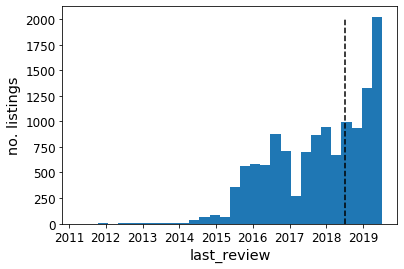

In [17]:
plt.figure()

# Histogram of last review date for unavailable properties
plt.hist(unavailable_reviewed.last_review, bins = 30)

# Dashed line gives date one year ago
last_year = pd.Timestamp('2018-07-08T12')
plt.plot([last_year, last_year], [0, 2000], color = 'k', linestyle = '--');

plt.xlabel('last_review')
plt.ylabel('no. listings')

plt.show()
plt.close()

Can't separate those that are completely 'dead' and those that are just not on the market at the moment. But 40% have  been reviewed in the last year so a significant percentage are still relevant.

# Motivating question: how are hosts using Airbnb?

Are hosts using it professionally (as their main source of income) or in a casual way. Do they have more than one property? Is it available all through the year or for a few days when they're away? Are they offering short- or long-term rentals?

# Focus on availability_365

We should be able to use availability_365 to gauge if hosts are renting out for the whole year or only a small part of it. Let's take a look at the distribution.

In [18]:
# Focus on availability_365
nyc_2019.availability_365.describe()

count    48895.000000
mean       112.781327
std        131.622289
min          0.000000
25%          0.000000
50%         45.000000
75%        227.000000
max        365.000000
Name: availability_365, dtype: float64

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


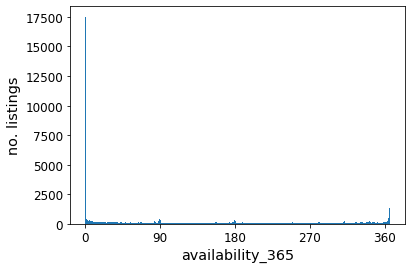

In [19]:
# Histogram of availability_365
plt.figure()

plt.hist(nyc_2019.availability_365, bins = range(0, 367, 1))

plt.xlabel('availability_365')
plt.ylabel('no. listings')

ax = plt.subplot()
ax.set_xticks(range(0, 366, 90))

plt.show()

plt.close()

There are spikes at 0 at and 365. What proportion of the data do these make up?

In [20]:
# What proportion of listings have availability 364 or 365?
round(len(nyc_2019[nyc_2019.availability_365 >= 364])/len(nyc_2019) * 100, 1)

3.7

So unavailable properties make up 36% of the data and properties available all year round make up around 4%

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


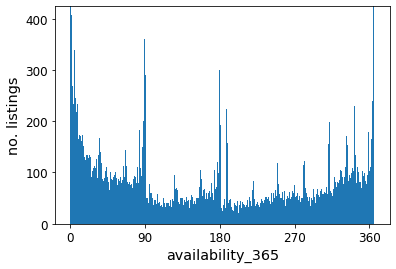

In [21]:
# Histogram of availability_365 with high counts cut off
plt.figure()

plt.hist(nyc_2019.availability_365, bins = range(0, 367, 1))

# Cut off high counts at x = 0 and x = 364, 365
plt.axis(ymax = 425)

plt.xlabel('availability_365')
plt.ylabel('no. listings')

ax = plt.subplot()
ax.set_xticks(range(0, 366, 90))
ax.set_yticks(range(0, 500, 100))

#plt.savefig('availability_365_hist.png')
plt.show()

plt.close()

What are those peaks? Peaks at 90 and 180 are probably because they're round numbers but there appear to be regular peaks besides those.

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


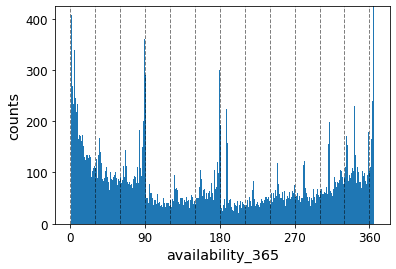

In [22]:
# Try to match spikes on previous fig to round numbers (multiples of 30)
plt.figure()

plt.hist(available.availability_365, bins = range(1, 367, 1))

# Dashed vertical lines at multiples of 30
for x in range(0, 390, 30):
    plt.plot([x, x], [0, 425], color = 'k', linestyle = '--', alpha = 0.5, linewidth = 1)

plt.axis(ymax = 425)
plt.xlabel('availability_365')
plt.ylabel('counts')

ax = plt.subplot()
ax.set_xticks(range(0, 366, 90))
ax.set_yticks(range(0, 500, 100))

plt.show()
plt.close()

Regular spikes seem to occur a few days after multiples of 30. Don't understand why this should be but probably isn't that important.

# Focus on minimum_nights

This statistic can indicate whether hosts want short- or long-term occupants.

In [23]:
# Focus on minimum_nights
nyc_2019.minimum_nights.describe()


count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

Clearly some outliers here - no one requires tenants to stay for 4 years. How many properties have a minimum stay of over say 6 months?

In [24]:
round(len(nyc_2019[nyc_2019.minimum_nights >= 188]) / len(nyc_2019) * 100, 1)

0.2

0.2% - isn't siginificant. Won't lose anything by keeping these in the dataset.

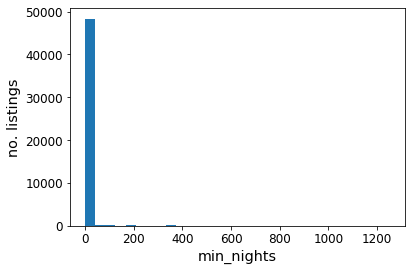

In [25]:
# Histogram of minimum_nights
plt.figure()

plt.hist(nyc_2019.minimum_nights, bins = 30)

plt.xlabel('min_nights')
plt.ylabel('no. listings')

plt.show()
plt.close()

99% of data points have min_nights < 36 so no problem with only going up to 35 on x-axis.

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


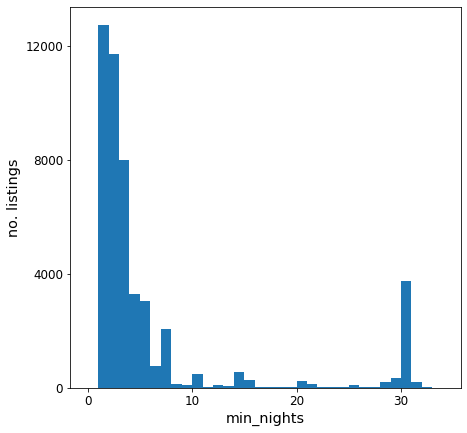

In [26]:
# Histogram of minimum_nights up to x = 35
plt.figure(figsize = (7, 7))

plt.hist(nyc_2019.minimum_nights, bins = range(0,35))

plt.xlabel('min_nights')
plt.ylabel('no. listings')

ax = plt.subplot()
ax.set_xticks(range(0, 40, 10))
ax.set_yticks(range(0, 16000, 4000))

#plt.savefig('minimum_nights_hist.png')
plt.show()

plt.close()

To get an intuitive measure of the distribution I want to find bin values that give roughly even heights.

In [27]:
# Trial and error to find bins that give bin_values of roughly even heights
min_nights_bins = [1 ,2 ,3, 4, 7, 30, 1250]

for i in range(len(min_nights_bins)-1):
    xmin = min_nights_bins[i]
    xmax = min_nights_bins[i + 1]
    percentile = round(len(nyc_2019[(nyc_2019.minimum_nights >= xmin)&(nyc_2019.minimum_nights < xmax)])/len(nyc_2019)*100, 1)
    print(xmin, xmax, percentile)

1 2 26.0
2 3 23.9
3 4 16.4
4 7 14.5
7 30 10.0
30 1250 9.2


So 65% of listings allow short-term stays (<4 nights) but a significant proportion require a longer stay.

# Covariance of min_nights and availability_365

I'm interested in how these two variables interact. A 2-dimensional histogram (i.e. heatmap) might be a good way to show this.

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


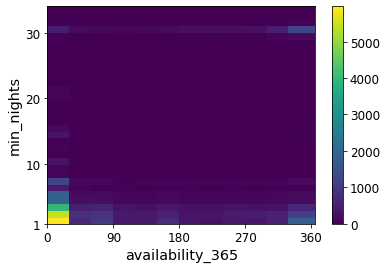

In [28]:
# 2-dimensional histogram of availability_365 against min_nights
# Work only with available listings, else detail is obscured
# Compare with unavailable listings afterwards using figure above
plt.figure()

availability_bin = list(range(0, 360, 30)) + [366]

plt.hist2d(nyc_2019.availability_365, nyc_2019.minimum_nights, bins = (availability_bin, range(1, 35)))
plt.colorbar()

ax = plt.subplot()
ax.set_xticks(range(0, 365, 90))
ax.set_yticks([1] + list(range(10, 40, 10)))

plt.xlabel('availability_365')
plt.ylabel('min_nights')

plt.show()
plt.close()

Unavailable properties are so numerous that they drown out everything else. For now I will just exclude properties with availability = 0. I feel okay about this because unavailable properties are either:
- properties which haven't been listed for a while;
- properties which are currently unavailable because they are fully booked or the host only puts them up at specific times (say when they're away).

So, we should expect unavailable properties to be a mixture of different host behaviours and not a reliable indicator.

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


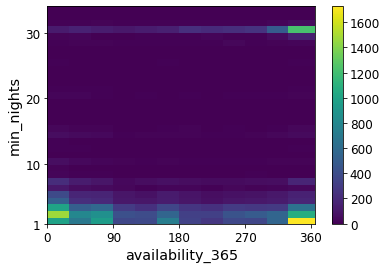

In [29]:
# 2-dimensional histogram of availability_365 against min_nights
# Work only with available listings, else detail is obscured
plt.figure()

availability_bin = list(range(0, 360, 30)) + [366]

plt.hist2d(available.availability_365, available.minimum_nights, bins = (availability_bin, range(1, 35)))
plt.colorbar()

ax = plt.subplot()
ax.set_xticks(range(0, 365, 90))
ax.set_yticks([1] + list(range(10, 40, 10)))

plt.xlabel('availability_365')
plt.ylabel('min_nights')

#plt.savefig('min_nights_availability_hist2d.png')
plt.show()

plt.close()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


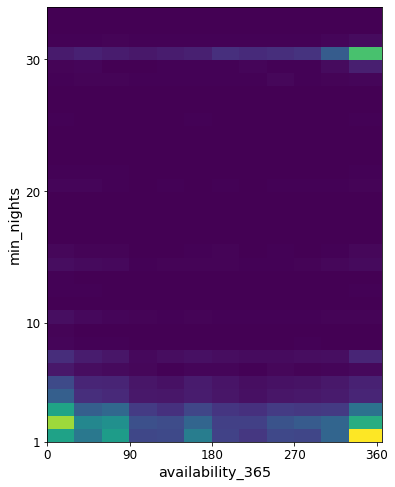

In [30]:
# Same plot without but taller without colourbar
plt.figure(figsize = (6, 8))

availability_bin = list(range(0, 360, 30)) + [366]

plt.hist2d(available.availability_365, available.minimum_nights, bins = (availability_bin, range(1, 35)))

ax = plt.subplot()
ax.set_xticks(range(0, 365, 90))
ax.set_yticks([1] + list(range(10, 40, 10)))

plt.xlabel('availability_365')
plt.ylabel('min_nights')

#plt.savefig('min_nights_availability_hist2d_2.png')
plt.show()

plt.close()

Notice three hot spots:
- Bottom left: short-term listing, low availability - traditional Airbnb model
- Bottom right: short-term listing, high availability - traditional hotel model
- Top right: long-term listing, high availability - like a short-term tenancy

I'm interested in taking horizontal slices of this picture and seeing how the number of short-, medium-, and long-term listings changes with availability.

First I want to briefly compare the distribution of min_nights between available and unavailable properties.

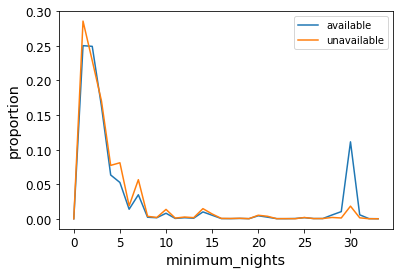

In [31]:
# Compare distribution of minimum_nights among available and unavailable properties
plt.figure()

# Generate heights for the plot
# Normalise (density = True) to make up for different numbers of counts
plot1 = plt.hist(available.minimum_nights, bins = range(0, 35), density = True)
plot2 = plt.hist(unavailable.minimum_nights, bins = range(0, 35), density = True)
plt.close()

plt.figure()

# Plot using line graph as it's easier to compare the two than with a bar chart
plt.plot(plot1[0], label = 'available')
plt.plot(plot2[0], label = 'unavailable')

plt.legend()

plt.xlabel('minimum_nights')
plt.ylabel('proportion')

plt.show()

This plot shows what proportion of listings have a given value of minimum_nights amongst available and unavailable properties. The distributions look roughly the same except for the large spike at 30 for available properties. This makes sense; we should expect a large proportion of unavailable properties to be short-term listings that happen to unavailable at the moment, so they should have a similar distribution of min_nights as those with low availability. Looking at the heat map, properties with a low value of availability don't have a spike at in_nights = 30.

# How do long- and short-term listings change as a proportion as availability changes

I want to fix a value (or range of values) of min_nights, see what proportion of listings have this value, and how this proportion changes with min_nights.

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


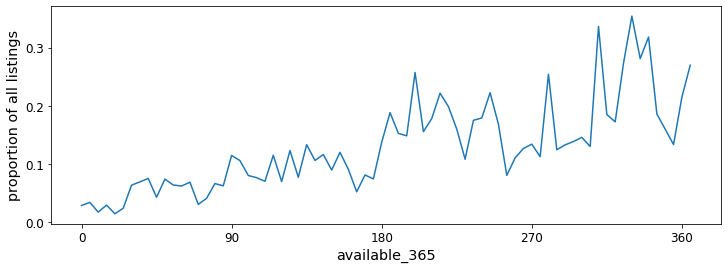

In [32]:
# Examine relationship between long-term listings (min_nights >= 30) and availability_365
# Change in counts of availability_365 make it necessary to normalise

# Bin availability_365 at width 5
# For each bin calculate long-term listings as a proportion of all listings in bin
bins = range(0, 370, 5)
bin_values = []

for x in bins:
    availability_in_bin = nyc_2019[(nyc_2019.availability_365 >= x)&(nyc_2019.availability_365 < x+5)]
    proportion_long_term = len(availability_in_bin[availability_in_bin.minimum_nights >= 30])/len(availability_in_bin)
    bin_values += [proportion_long_term]
    
# Generate histogram of long-term listings (min_nights >= 30) as a proportion of all listings against availibility_365
plt.figure(figsize = (12, 4))    
    
plt.plot(bins, bin_values)

ax = plt.subplot()
ax.set_xticks(range(0, 365, 90))
ax.set_yticks([0, 0.1, 0.2, 0.3])

plt.xlabel('available_365')
plt.ylabel('proportion of all listings')

#plt.savefig('long_term_listings_availability.png')
plt.show()

plt.close()


Long-term listings increase as a proportion of all listings at a fairly constant rate. What about short-term listings?

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


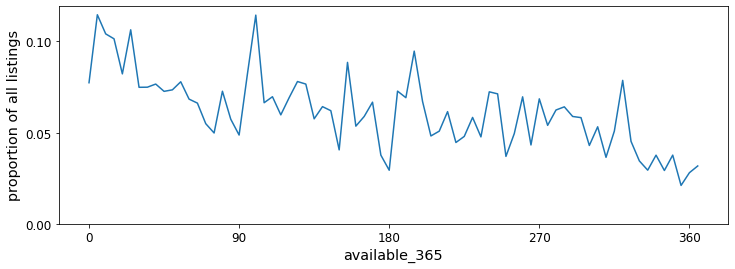

In [38]:
# Repeat procedure for short-term listings (e.g. min_nights == 4) and compare
# Generate bin_values
bins = range(0, 370, 5)
bin_values = []

for x in bins:
    availability_in_bin = nyc_2019[(nyc_2019.availability_365 >= x)&(nyc_2019.availability_365 < x+5)]
    proportion_long_term = len(availability_in_bin[availability_in_bin.minimum_nights == 4])/len(availability_in_bin)
    bin_values += [proportion_long_term]

# Plot histogram
plt.figure(figsize = (12, 4))    
    
plt.plot(bins, bin_values)

ax = plt.subplot()
ax.set_xticks(range(0, 365, 90))
ax.set_yticks([0, 0.05, 0.1])

plt.xlabel('available_365')
plt.ylabel('proportion of all listings')

#plt.savefig('short_term_listings_availability.png')
plt.show()

plt.close()


Here it decreases. What about medium-term?

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


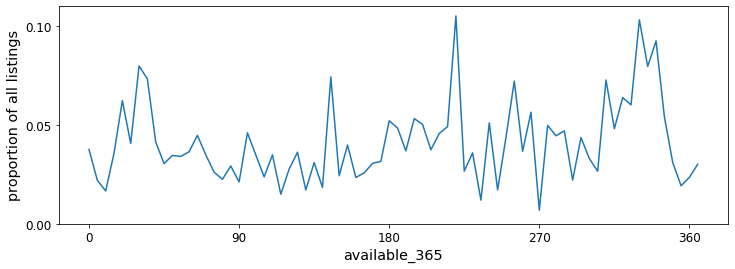

In [41]:
# Repeat procedure for medium-term listings (e.g. 14 <= min_nights < 30) and compare
# Generate bin_values
bins = range(0, 370, 5)
bin_values = []

for x in bins:
    availability_in_bin = nyc_2019[(nyc_2019.availability_365 >= x)&(nyc_2019.availability_365 < x+5)]
    proportion_long_term = len(availability_in_bin[(availability_in_bin.minimum_nights >= 14) & (availability_in_bin.minimum_nights < 30)])/len(availability_in_bin)
    bin_values += [proportion_long_term]

# Plot histogram
plt.figure(figsize = (12, 4))    
    
plt.plot(bins, bin_values)

ax = plt.subplot()
ax.set_xticks(range(0, 365, 90))
ax.set_yticks([0, 0.05, 0.1])

plt.xlabel('available_365')
plt.ylabel('proportion of all listings')

#plt.savefig('short_term_listings_availability.png')
plt.show()

plt.close()

Here it seems fairly stochastic with constant mean.

Experiments along these lines suggest that short-term listings decrease as a proportion as availability increases, medium-term stay roughly constant, and long-term increase. The change between short- and medium-term listings appears to be gradual whereas the change with long-term listings happens immediately at min_nights == 30. Some searching online suggests that properties with min_nights >= 30 might be markedly different from others because of laws in NYC; long-term rentals are defined as rentals of at least 30 days and are treated differently under NYC law.